In [ ]:
# | default_exp schedulers/cyclic

# Imports

In [ ]:
# | export


import math
from enum import Enum

from torch.optim.lr_scheduler import LRScheduler

In [ ]:
from matplotlib import pyplot as plt
from torch import nn
from torch.optim import Adam

# Scheduler

### Sine

In [ ]:
# | export


class SineScheduler:
    def __init__(self, start_value: float, max_value: float, decay: float = 0.0, wavelength: int | None = None):
        assert 0.0 <= decay < 1.0, "Decay must be between 0 and 1"

        self.start_value = start_value
        self.max_value = max_value
        self.decay_factor = 1 - decay
        self.wavelength = None

        self.pseudo_max_value = max_value / (self.decay_factor**0.5)

        self.x = 1

        if wavelength is not None:
            self.set_wavelength(wavelength)

    def set_wavelength(self, wavelength: int):
        assert wavelength > 0, "Wavelength must be greater than 0"
        self.wavelength = wavelength
        return self  # to allow chaining

    def is_ready(self):
        return self.wavelength is not None

    def get(self):
        if not self.is_ready():
            raise ValueError("Call set_wavelength first")

        # Calculate angle based on current step and wavelength and get sine value
        angle = (-0.5 + 2 * self.x / self.wavelength) * math.pi
        sine = math.sin(angle)

        # Scale it to the range of pseudo_max_lr and max_lr
        scaled = (self.pseudo_max_value - self.start_value) * (1 + sine) / 2

        # Apply decay to it
        decayed = scaled * self.decay_factor ** ((self.x + 1) / self.wavelength)

        # Increase it by the start_lr
        y = decayed + self.start_value

        return y

    def step(self):
        if not self.is_ready():
            raise ValueError("Call set_wavelength first")
        self.x = self.x + 1

    def __repr__(self):
        _repr = (
            "SineScheduler(\n"
            f"  start_value={self.start_value},\n"
            f"  max_value={self.max_value},\n"
            f"  decay={self.decay},\n"
        )
        if self.wavelength is not None:
            _repr += f"  wavelength={self.wavelength}\n"
        _repr += ")"

        return _repr

In [ ]:
scheduler = SineScheduler(0, 1, 0.9).set_wavelength(5)

for _ in range(15):
    print(f"Value: {scheduler.get()}")
    scheduler.step()

Value: 0.4349480324496454
Value: 0.7184766378640389
Value: 0.4533281114977514
Value: 0.10925400611220523
Value: 0.0
Value: 0.043494803244964526
Value: 0.07184766378640382
Value: 0.04533281114977513
Value: 0.010925400611220529
Value: 0.0
Value: 0.004349480324496461
Value: 0.007184766378640381
Value: 0.0045332811149775155
Value: 0.001092540061122056
Value: 0.0


In [ ]:
scheduler = SineScheduler(0, 1, 0).set_wavelength(14)

for _ in range(15):
    print(f"Value: {scheduler.get()}")
    scheduler.step()

Value: 0.04951556604879043
Value: 0.18825509907063326
Value: 0.3887395330218428
Value: 0.6112604669781572
Value: 0.8117449009293667
Value: 0.9504844339512095
Value: 1.0
Value: 0.9504844339512095
Value: 0.8117449009293667
Value: 0.6112604669781573
Value: 0.38873953302184283
Value: 0.18825509907063348
Value: 0.04951556604879048
Value: 0.0
Value: 0.04951556604879037


In [ ]:
# | export


class SineLR(LRScheduler):
    def __init__(self, optimizer, start_lr, max_lr, wavelength, decay, last_epoch=-1, verbose="deprecated"):
        self.scheduler = SineScheduler(start_lr, max_lr, decay).set_wavelength(wavelength)
        self.scheduler.x -= 1  # To match the output of the non-LR scheduler
        super().__init__(optimizer, last_epoch, verbose)

    def get_lr(self):
        lr = self.scheduler.get()
        return [lr for _ in self.optimizer.param_groups]

    def step(self, epoch=None):
        self.scheduler.step()
        return super().step(epoch)

In [ ]:
optimizer = Adam([nn.Parameter()])
scheduler = SineLR(optimizer, 0, 1, 5, 0.9)

for _ in range(15):
    print(f"Value: {scheduler.get_lr()}")
    scheduler.step()

Value: [0.4349480324496454]
Value: [0.7184766378640389]
Value: [0.4533281114977514]
Value: [0.10925400611220523]
Value: [0.0]
Value: [0.043494803244964526]
Value: [0.07184766378640382]
Value: [0.04533281114977513]
Value: [0.010925400611220529]
Value: [0.0]
Value: [0.004349480324496461]
Value: [0.007184766378640381]
Value: [0.0045332811149775155]
Value: [0.001092540061122056]
Value: [0.0]


/home/users/arjun.agarwal/miniforge3/envs/env/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


### Cyclic annealing

In [ ]:
# | export


class Phase(Enum):
    UP = 1
    TOP = 2
    DOWN = 3
    BOTTOM = 4


class CyclicAnnealingScheduler:
    """Cyclic Annealing Schedule, inspired by the paper `Cyclical Annealing Schedule: A Simple Approach to Mitigating KL
    Vanishing <https://arxiv.org/pdf/1903.10145v3>`_.
    """

    NOT_READY_ERROR_MSG = "Number of steps for each phase must be set before using the scheduler"

    def __init__(
        self,
        start_value: float,
        max_value: float,
        up_annealing_steps: int | None = None,
        top_fixed_steps: int | None = None,
        down_annealing_steps: int | None = None,
        bottom_fixed_steps: int | None = None,
    ):
        self.start_value = start_value
        self.max_value = max_value

        self.num_annealing_steps = {
            "up": None,
            "top": None,
            "down": None,
            "bottom": None,
        }

        self.phase = None
        self.x = 0

        self.set_num_annealing_steps(up_annealing_steps, top_fixed_steps, down_annealing_steps, bottom_fixed_steps)

    def set_num_annealing_steps(
        self,
        up_annealing_steps: int | None = None,
        top_annealing_steps: int | None = None,
        down_annealing_steps: int | None = None,
        bottom_annealing_steps: int | None = None,
    ):
        if up_annealing_steps is not None:
            assert up_annealing_steps >= 0, "Up annealing steps must >= 0"
            self.num_annealing_steps["up"] = up_annealing_steps
        if top_annealing_steps is not None:
            assert top_annealing_steps >= 0, "Top fixed steps must >= 0"
            self.num_annealing_steps["top"] = top_annealing_steps
        if down_annealing_steps is not None:
            assert down_annealing_steps >= 0, "Down annealing steps must >= 0"
            self.num_annealing_steps["down"] = down_annealing_steps
        if bottom_annealing_steps is not None:
            assert bottom_annealing_steps >= 0, "Bottom fixed steps must >= 0"
            self.num_annealing_steps["bottom"] = bottom_annealing_steps

        if self.is_ready():
            self.set_next_phase()

        return self

    def set_next_phase(self):
        if self.phase is None:
            self.phase = Phase.BOTTOM

        while True:  # Keep updating the phase till that phase has annealing steps > 0
            if self.phase == Phase.UP:
                self.phase = Phase.TOP
            elif self.phase == Phase.TOP:
                self.phase = Phase.DOWN
            elif self.phase == Phase.DOWN:
                self.phase = Phase.BOTTOM
            elif self.phase == Phase.BOTTOM:
                self.phase = Phase.UP

            if self.num_annealing_steps[self.phase.name.lower()] > 0:
                break

    def is_ready(self):
        if (
            self.num_annealing_steps["up"] is None
            or self.num_annealing_steps["top"] is None
            or self.num_annealing_steps["down"] is None
            or self.num_annealing_steps["bottom"] is None
        ):
            return False

        if (
            self.num_annealing_steps["up"] == 0
            and self.num_annealing_steps["top"] == 0
            and self.num_annealing_steps["down"] == 0
            and self.num_annealing_steps["bottom"] == 0
        ):
            return False

        return True

    def get(self):
        if not self.is_ready():
            raise ValueError(self.NOT_READY_ERROR_MSG)

        if self.phase == Phase.UP:
            y = self.start_value + (self.max_value - self.start_value) * (self.x / self.num_annealing_steps["up"])
        elif self.phase == Phase.TOP:
            y = self.max_value
        elif self.phase == Phase.DOWN:
            y = self.max_value - (self.max_value - self.start_value) * (self.x / self.num_annealing_steps["down"])
        elif self.phase == Phase.BOTTOM:
            y = self.start_value

        return y

    def step(self):
        if not self.is_ready():
            raise ValueError(self.NOT_READY_ERROR_MSG)

        self.x = self.x + 1
        if self.x >= self.num_annealing_steps[self.phase.name.lower()]:
            self.x = 0
            self.set_next_phase()

    def __repr__(self):
        _repr = (
            "CyclicAnnealingScheduler(\n"
            f"  start_value={self.start_value},\n"
            f"  max_value={self.max_value},\n"
            f"  up_annealing_steps={self.num_annealing_steps['up']},\n"
            f"  top_fixed_steps={self.num_annealing_steps['top']},\n"
            f"  down_annealing_steps={self.num_annealing_steps['down']},\n"
            f"  bottom_fixed_steps={self.num_annealing_steps['bottom']},\n"
            ")"
        )

        return _repr

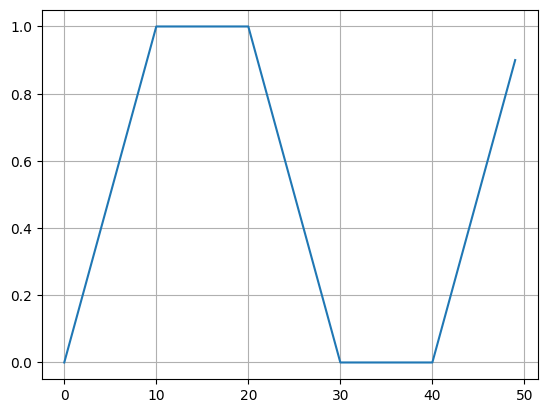

In [ ]:
scheduler = CyclicAnnealingScheduler(0, 1, 10, 10, 10, 10)

values = []
for _ in range(50):
    value = scheduler.get()
    values.append(value)
    scheduler.step()

plt.plot(values)
plt.grid()
plt.show()

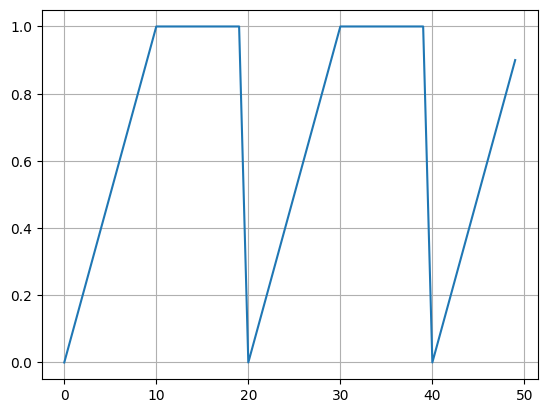

In [ ]:
scheduler = CyclicAnnealingScheduler(0, 1, 10, 10, 0, 0)

values = []
for _ in range(50):
    value = scheduler.get()
    values.append(value)
    scheduler.step()

plt.plot(values)
plt.grid()
plt.show()

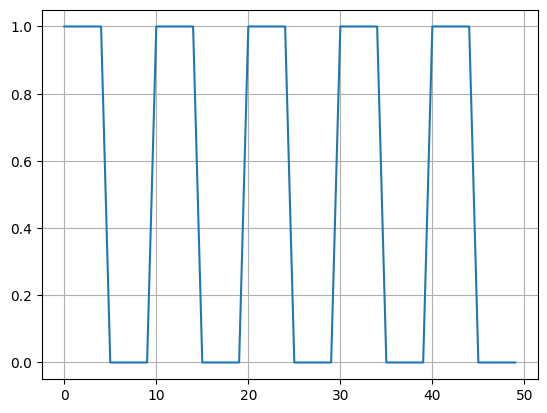

In [ ]:
scheduler = CyclicAnnealingScheduler(0, 1, 0, 5, 0, 5)

values = []
for _ in range(50):
    value = scheduler.get()
    values.append(value)
    scheduler.step()

plt.plot(values)
plt.grid()
plt.show()

In [ ]:
# | export


class CyclicAnnealingLR(LRScheduler):
    def __init__(
        self,
        optimizer,
        start_lr,
        max_lr,
        up_annealing_steps: int,
        top_fixed_steps: int,
        down_annealing_steps: int,
        bottom_fixed_steps: int,
        last_epoch=-1,
        verbose="deprecated",
    ):
        self.scheduler = CyclicAnnealingScheduler(
            start_lr, max_lr, up_annealing_steps, top_fixed_steps, down_annealing_steps, bottom_fixed_steps
        )
        self.scheduler.x -= 1  # To match the output of the non-LR scheduler
        super().__init__(optimizer, last_epoch, verbose)

    def get_lr(self):
        lr = self.scheduler.get()
        return [lr for _ in self.optimizer.param_groups]

    def step(self, epoch=None):
        self.scheduler.step()
        return super().step(epoch)

In [ ]:
optimizer = Adam([nn.Parameter()])
scheduler = CyclicAnnealingLR(optimizer, 0, 1, 5, 5, 5, 5)

for _ in range(20):
    print(f"Value: {scheduler.get_lr()}")
    scheduler.step()

Value: [0.0]
Value: [0.2]
Value: [0.4]
Value: [0.6]
Value: [0.8]
Value: [1]
Value: [1]
Value: [1]
Value: [1]
Value: [1]
Value: [1.0]
Value: [0.8]
Value: [0.6]
Value: [0.4]
Value: [0.19999999999999996]
Value: [0]
Value: [0]
Value: [0]
Value: [0]
Value: [0]


# nbdev

In [ ]:
!nbdev_export